In [ ]:
import os
import json
import cv2
import warnings
import random
import shutil
import itertools
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
os.environ['OPENCV_LOG_LEVEL'] = 'ERROR'  # Suppress all OpenCV warnings


In [2]:
# Define target image size
target_size = (224, 224)  # Standard size for models like ResNet

In [3]:
def load_image(img_path, target_size):
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # Ensure 3 channels
            img = img.resize(target_size)
            return np.array(img)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def getting_images_and_lables(base_dir, disease_classes, target_size=(224, 224)):
    images = []
    labels = []
    sizes = []
    for disease in disease_classes:
        class_dir = os.path.join(base_dir, disease)
        if not os.path.exists(class_dir):
            print(f"Directory does not exist: {class_dir}")
            continue
        for img_name in os.listdir(class_dir):
            # Skip hidden or system files
            if img_name.startswith('.'):
                continue
            img_path = os.path.join(class_dir, img_name)
            img = load_image(img_path, target_size)
            if img is not None:
                try:
                    original_img = Image.open(img_path)
                    width, height = original_img.size
                    sizes.append((width, height))
                    original_img.close()
                except:
                    sizes.append((0, 0))
                images.append(img)
                labels.append(disease)
            else:
                # Remove corrupted image
                os.remove(img_path)
                print(f"Deleted corrupted image: {img_path}")
    return images, labels, sizes

# Define Directory for all Plant Classes from the Dataset and Get Images, Labels and Sizes of each image
cashew_base_dir = "DataPlant/Cashew"  
cashew_disease_classes = ["anthracnose", "gumosis", "healthy", "leaf_miner", "red_rust"]
cashew_images, cashew_labels, cashew_image_sizes = getting_images_and_lables(cashew_base_dir, cashew_disease_classes)
cashew_labels_series = pd.Series(cashew_labels)

cassava_base_dir = "DataPlant/Cassava"
cassava_disease_classes = [ "bacterial_blight", "brown_spot", "green_mite", "healthy", "mosaic"]
cassava_images, cassava_labels, cassava_image_sizes = getting_images_and_lables(cassava_base_dir, cassava_disease_classes)
cassava_labels_series = pd.Series(cassava_labels)

maize_base_dir = "DataPlant/Maize"
maize_disease_classes = ["fall_armyworm", "grasshoper", "healthy", "leaf_beetle", "leaf_blight", "leaf_spot", "streak_virus"]
maize_images, maize_labels, maize_image_sizes = getting_images_and_lables(maize_base_dir, maize_disease_classes)
maize_labels_series = pd.Series(maize_labels)

tomato_base_dir = "DataPlant/Tomato"
tomato_disease_classes = ["healthy", "leaf_blight", "leaf_curl", "septoria_leaf_spot", "verticulium_wilt" ]
tomato_images, tomato_labels, tomato_image_sizes = getting_images_and_lables(tomato_base_dir, tomato_disease_classes)
tomato_labels_series = pd.Series(tomato_labels)


In [4]:
def remove_corrupt_images_tf(base_path):
    for root, _, files in os.walk(base_path):
        for fname in files:
            fpath = os.path.join(root, fname)  # Ensure fpath is defined for all cases
            # Skip hidden or system files
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_data = tf.io.read_file(fpath)
                    _ = tf.image.decode_jpeg(img_data, channels=3)  # force decode
                except Exception as e:
                    print(f"Removing corrupt image: {fpath} | Error: {e}")
                    os.remove(fpath)
            else:
                print(f"Skipping non-image file: {fpath}")
remove_corrupt_images_tf("DataPlant")

def remove_ds_store_files(base_dir):
    for root, dirs, files in os.walk(base_dir):
        if '.DS_Store' in files:
            os.remove(os.path.join(root, '.DS_Store'))
            print(f"Removed .DS_Store file from {root}")

# Caling this to remove any .DS_Store files that might have been created
remove_ds_store_files("DataPlant")

2025-05-14 22:55:48.271713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-14 22:55:48.271754: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 22:55:48.271758: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-14 22:55:48.271787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-14 22:55:48.271804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Function to display Images of Each Plant Class and Disease to each Class
def display_images_for_plant(base_dir, disease_classes, plant_name, num_images=1):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{plant_name} Images", fontsize=14)
    
    for i, disease in enumerate(disease_classes):
        class_dir = os.path.join(base_dir, disease)
        # Get list of images in the class directory
        image_files = [f for f in os.listdir(class_dir) if not f.startswith('.')]  # Skip hidden files
        if len(image_files) == 0:
            print(f"No images found for class: {disease}")
            continue
        # Randomly sample `num_images` from the class
        random_images = np.random.choice(image_files, min(num_images, len(image_files)), replace=False)
        # Display the sampled images
        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                plt.subplot(1, len(disease_classes), i+ 1)
                plt.imshow(img)
                plt.title(disease)
                plt.axis("off")
            else:
                print(f"Failed to load image: {img_path}")
    plt.tight_layout()
    plt.show()

# Display random images for each disease class of a plant.
display_images_for_plant(cashew_base_dir, cashew_disease_classes, "Cashew")
display_images_for_plant(cassava_base_dir, cassava_disease_classes, "Cassava")
display_images_for_plant(maize_base_dir, maize_disease_classes, "Maize")
display_images_for_plant(tomato_base_dir, tomato_disease_classes, "Tomato")

'display_images_for_plant(cashew_base_dir, cashew_disease_classes, "Cashew")\ndisplay_images_for_plant(cassava_base_dir, cassava_disease_classes, "Cassava")\ndisplay_images_for_plant(maize_base_dir, maize_disease_classes, "Maize")\ndisplay_images_for_plant(tomato_base_dir, tomato_disease_classes, "Tomato")'

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Cashew class distribution
sns.countplot(x=cashew_labels_series, ax=axes[0, 0])
axes[0, 0].set_title("Class Distribution (Cashew Leaves)")
axes[0, 0].set_xlabel("Disease Class")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot Cassava class distribution
sns.countplot(x=cassava_labels_series, ax=axes[0, 1])
axes[0, 1].set_title("Class Distribution (Cassava Leaves)")
axes[0, 1].set_xlabel("Disease Class")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot Maize class distribution
sns.countplot(x=maize_labels_series, ax=axes[1, 0])
axes[1, 0].set_title("Class Distribution (Maize Leaves)")
axes[1, 0].set_xlabel("Disease Class")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', rotation=45)


# Plot tomato class distributio
sns.countplot(x=tomato_labels_series, ax=axes[1, 1])
axes[1, 1].set_title("Class Distribution (Tomato Leaves)")
axes[1, 1].set_xlabel("Disease Class")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=45)


# Adjust layout and display
plt.tight_layout()
plt.show()

'# Create a 2x2 grid of subplots\nfig, axes = plt.subplots(2, 2, figsize=(12, 10))\n\n# Plot Cashew class distribution\nsns.countplot(x=cashew_labels_series, ax=axes[0, 0])\naxes[0, 0].set_title("Class Distribution (Cashew Leaves)")\naxes[0, 0].set_xlabel("Disease Class")\naxes[0, 0].set_ylabel("Count")\naxes[0, 0].tick_params(axis=\'x\', rotation=45)\n\n# Plot Cassava class distribution\nsns.countplot(x=cassava_labels_series, ax=axes[0, 1])\naxes[0, 1].set_title("Class Distribution (Cassava Leaves)")\naxes[0, 1].set_xlabel("Disease Class")\naxes[0, 1].set_ylabel("Count")\naxes[0, 1].tick_params(axis=\'x\', rotation=45)\n\n# Plot Maize class distribution\nsns.countplot(x=maize_labels_series, ax=axes[1, 0])\naxes[1, 0].set_title("Class Distribution (Maize Leaves)")\naxes[1, 0].set_xlabel("Disease Class")\naxes[1, 0].set_ylabel("Count")\naxes[1, 0].tick_params(axis=\'x\', rotation=45)\n\n\n# Plot tomato class distributio\nsns.countplot(x=tomato_labels_series, ax=axes[1, 1])\naxes[1, 1].s

In [7]:
# Plot the distribution of image sizes (width and height).
def plot_size_distribution(sizes, plant_name):
    # Suppress FutureWarnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # Convert sizes to a pandas DataFrame
    sizes_df = pd.DataFrame(sizes, columns=["Width", "Height"])

    sizes_df["Width"] = pd.to_numeric(sizes_df["Width"], errors="coerce")
    sizes_df["Height"] = pd.to_numeric(sizes_df["Height"], errors="coerce")

    sizes_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
    sizes_df.dropna(subset=["Width", "Height"], inplace=True)  # Drop rows with NaN
    sizes_df = sizes_df[(sizes_df["Width"] > 0) & (sizes_df["Height"] > 0)]
    
    if sizes_df.empty:
        print(f"No valid data to plot for {plant_name}.")
        return

     # Check if all values are identical
    width_unique = sizes_df["Width"].nunique()
    height_unique = sizes_df["Height"].nunique()
    
    # Plot the distribution of widths and heights
    plt.figure(figsize=(8, 4))
    plt.suptitle(f"{plant_name} Original Image Size Distribution", fontsize=16)

    
    # Plot width distribution
    plt.subplot(1, 2, 1)
    # Handle identical values (e.g., Cassava)
    if width_unique == 1:
        sns.histplot( sizes_df["Width"], kde=False, bins=1, color="blue")
        plt.xticks([sizes_df["Width"].iloc[0]])  # Set x-ticks to the single value
    else:
        sns.histplot(sizes_df["Width"], kde=False, binwidth=50, color="blue")
        plt.xlim(190, 500)
    plt.title("Width Distribution")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Frequency")
    plt.grid(True)
    
    
    # Plot height distribution
    plt.subplot(1, 2, 2)
     # Handle identical values (e.g., Cassava)
    if height_unique == 1:
        sns.histplot(sizes_df["Height"], kde=False, bins=1, color="green")
        plt.xticks([sizes_df["Height"].iloc[0]])  # Set x-ticks to the single value
    else:
        sns.histplot(sizes_df["Height"], kde=False, binwidth=50, color="green")
        plt.xlim(190, 500)
    plt.title("Height Distribution")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Frequency")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Display the Frequency of the images sizes
'''plot_size_distribution(cashew_image_sizes, "Cashew")
plot_size_distribution(cassava_image_sizes, "Cassava")
plot_size_distribution(maize_image_sizes, "Maize")
plot_size_distribution(tomato_image_sizes, "Tomato")'''

'plot_size_distribution(cashew_image_sizes, "Cashew")\nplot_size_distribution(cassava_image_sizes, "Cassava")\nplot_size_distribution(maize_image_sizes, "Maize")\nplot_size_distribution(tomato_image_sizes, "Tomato")'

### Model Training Pipeline

#### Data Preparation
Duplicating the DataSet into seperate folder which subfolder name as "name_disease" Spliting the dataset into Training, Validation and Test sets.

In [8]:
source_dir = "DataPlant"        # Original DataSet From the Source
target_dir = "DataPlant_flat"   # Flattened DataSet for Model Training
test_dir = "DataPlant_test"    # Test directory
test_ratio = 0.1                # 10% of images from each class

# Check Whether Flat Dataset Folder exists or not is Exits or not
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Creating DataSet Flat Folder for Model Training, Validation and Testing
for plant_name in os.listdir(source_dir):
    plant_path = os.path.join(source_dir, plant_name)
    if os.path.isdir(plant_path):
        for disease_name in os.listdir(plant_path):
            disease_path = os.path.join(plant_path, disease_name)
            target_class_name = f"{plant_name.lower()}_{disease_name.lower().replace(' ', '_')}"
            target_class_dir = os.path.join(target_dir, target_class_name)
            os.makedirs(target_class_dir, exist_ok=True)
            for img_name in os.listdir(disease_path):
                src_img_path = os.path.join(disease_path, img_name)
                dst_img_path = os.path.join(target_class_dir, img_name)
                shutil.copy2(src_img_path, dst_img_path)
print(f"Flattened dataset created at: {target_dir}")


# Checking Whether Test Dataset Folder exists or not
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# For each Class, creating a Test Folder under the DataPlant_test Directory
for class_name in os.listdir(target_dir):
    class_path = os.path.join(target_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        num_test = int(len(images) * test_ratio)
        test_images = images[:num_test]
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(test_class_dir, exist_ok=True)
        for img_name in tqdm(test_images, desc=f"Moving test images for {class_name}"):
            src = os.path.join(class_path, img_name)
            dst = os.path.join(test_class_dir, img_name)
            shutil.move(src, dst)


Flattened dataset created at: DataPlant_flat


Moving test images for cashew_healthy: 100%|██████████| 136/136 [00:00<00:00, 11048.97it/s]


In [9]:
# Dataset parameters
batch_size = 64
img_size = (224, 224)
print("Training and Validation Data")
# Load datasets
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    target_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    target_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)
print("Testing Data")
test_dir = "DataPlant_test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, label_mode="int"
)
num_test_files = len(test_ds.file_paths)
print(f"Using {num_test_files} files for testing.")

class_names = train_ds_raw.class_names
num_classes = len(class_names)

Training and Validation Data
Found 22613 files belonging to 22 classes.
Using 18091 files for training.
Found 22613 files belonging to 22 classes.
Using 4522 files for validation.
Testing Data
Found 4722 files belonging to 22 classes.
Using 4722 files for testing.


#### Data Augmentation and Model Building (Transfer Learning)
Modifying the training images to improve the generalization and Using the pretrained deep learing model EfficientNetB3 to extract features, in addition with freezing the pre-trained weight to avoid changes.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation for diversifying the Dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


# Loading the EfficientNetB3 model
base_model = tf.keras.applications.EfficientNetB3(
    input_shape=img_size+(3,),
    include_top=False,
    weights='imagenet')
base_model.trainable = False
for layer in base_model.layers[-60:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')])

# Introducing ADAM Optimizer for class imbalance
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # One-hot encode the labels since y_true is integer-based
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = tf.reduce_sum(focal_weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return loss
fine_tune_lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=fine_tune_lr)
model.compile(optimizer=optimizer, 
              loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
                metrics=['accuracy'])


In [11]:
# This shows the weight of images from each class in our training dataset (Class Imbalance)
all_labels = []
for images, labels in train_ds_raw:
    all_labels.extend(labels.numpy())

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(all_labels), 
    y=all_labels)

class_weights = {i: w for i, w in enumerate(class_weights)}
for i, w in class_weights.items():
    print(f"Class {i}: {w:.4f}")

Class 0: 0.6573
Class 1: 2.9902
Class 2: 0.8289
Class 3: 0.8174
Class 4: 0.6945
Class 5: 0.4312
Class 6: 0.7503
Class 7: 1.1068
Class 8: 0.9813
Class 9: 0.9584
Class 10: 4.1742
Class 11: 1.7096
Class 12: 5.5189
Class 13: 1.2347
Class 14: 1.1188
Class 15: 0.9229
Class 16: 1.1697
Class 17: 2.3905
Class 18: 0.8938
Class 19: 2.2285
Class 20: 0.4224
Class 21: 1.5256


2025-05-14 22:57:02.422612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('Plant_disease_detection_model.h5', 
                    save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=13,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/13


2025-05-14 22:57:37.758645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.4491 - loss: 0.3772

283/283 ━━━━━━━━━━━━━━━━━━━━ 188s 617ms/step - accuracy: 0.4497 - loss: 0.3767 - val_accuracy: 0.8229 - val_loss: 0.0671
Epoch 2/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7682 - loss: 0.0950

283/283 ━━━━━━━━━━━━━━━━━━━━ 173s 608ms/step - accuracy: 0.7683 - loss: 0.0949 - val_accuracy: 0.8481 - val_loss: 0.0516
Epoch 3/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8112 - loss: 0.0684

283/283 ━━━━━━━━━━━━━━━━━━━━ 167s 586ms/step - accuracy: 0.8112 - loss: 0.0684 - val_accuracy: 0.8571 - val_loss: 0.0478
Epoch 4/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8316 - loss: 0.0585

283/283 ━━━━━━━━━━━━━━━━━━━━ 189s 664ms/step - accuracy: 0.8316 - loss: 0.0585 - val_accuracy: 0.8662 - val_loss: 0.0437
Epoch 5/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8501 - loss: 0.0496

283/283 ━━━━━━━━━━━━━━━━━━━━ 193s 678ms/step - accuracy: 0.8502 - loss: 0.0496 - val_accuracy: 0.8739 - val_loss: 0.0402
Epoch 6/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8624 - loss: 0.0446

283/283 ━━━━━━━━━━━━━━━━━━━━ 188s 661ms/step - accuracy: 0.8624 - loss: 0.0446 - val_accuracy: 0.8757 - val_loss: 0.0402
Epoch 7/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8781 - loss: 0.0376

283/283 ━━━━━━━━━━━━━━━━━━━━ 1112s 4s/step - accuracy: 0.8781 - loss: 0.0376 - val_accuracy: 0.8832 - val_loss: 0.0401
Epoch 8/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8876 - loss: 0.0348 - val_accuracy: 0.8819 - val_loss: 0.0403
Epoch 9/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8987 - loss: 0.0301

283/283 ━━━━━━━━━━━━━━━━━━━━ 166s 585ms/step - accuracy: 0.8987 - loss: 0.0301 - val_accuracy: 0.8841 - val_loss: 0.0400
Epoch 10/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 177s 622ms/step - accuracy: 0.9105 - loss: 0.0274 - val_accuracy: 0.8850 - val_loss: 0.0424
Epoch 11/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 179s 632ms/step - accuracy: 0.9171 - loss: 0.0251 - val_accuracy: 0.8806 - val_loss: 0.0406
Epoch 12/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 189s 665ms/step - accuracy: 0.9169 - loss: 0.0230 - val_accuracy: 0.8885 - val_loss: 0.0427
Epoch 13/13
283/283 ━━━━━━━━━━━━━━━━━━━━ 191s 671ms/step - accuracy: 0.9259 - loss: 0.0198 - val_accuracy: 0.8881 - val_loss: 0.0416


In [13]:
model.save('Plant_disease_detection_model.h5')

### Performance Evaluation


71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.8830 - loss: 0.0418
Validation Loss: 0.0400
Validation Accuracy: 0.8841


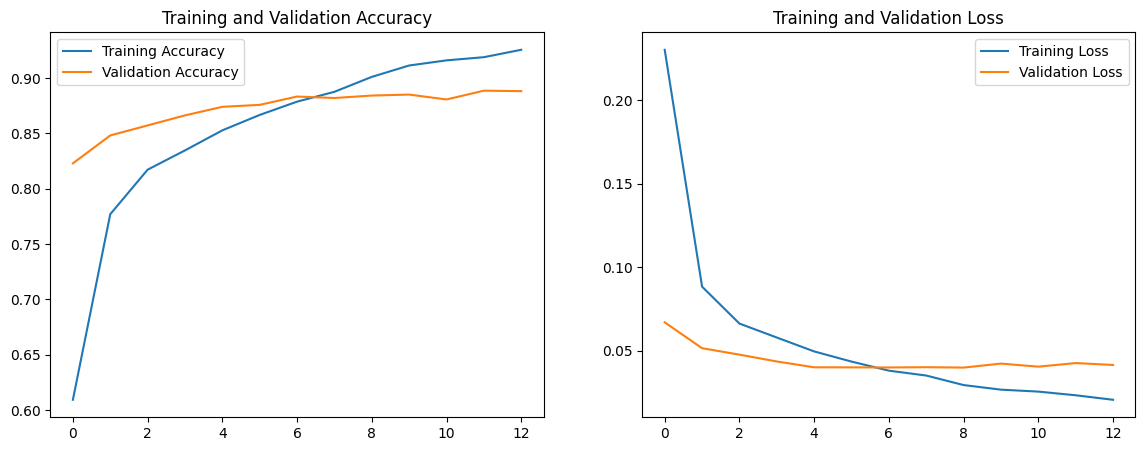

In [14]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plotting training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
plot_training_history(history)

# Save history dict to a JSON file after training
with open('history.json', 'w') as f:
    json.dump(history.history, f)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2025-05-15 01:05:45.737944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


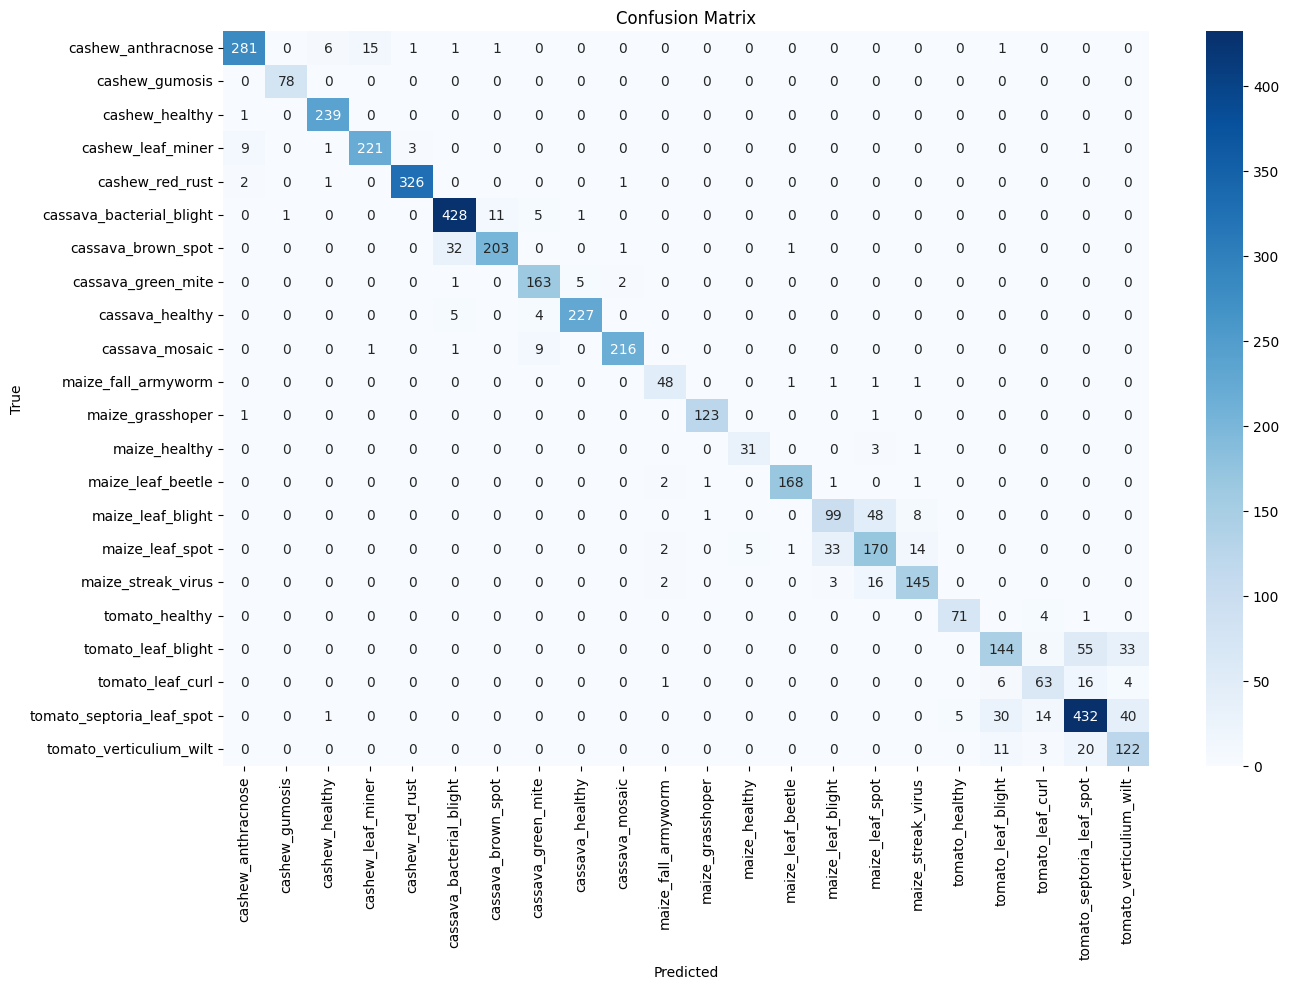

In [ ]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Print classification report
class_names = train_ds_raw.class_names
# You can map the predicted and true labels back to class names:
y_true_class_names = [class_names[i] for i in y_true]
y_pred_class_names = [class_names[i] for i in y_pred]
print(classification_report(y_true_class_names, y_pred_class_names, target_names=class_names))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Found 4722 files belonging to 22 classes.
['cashew_anthracnose', 'cashew_gumosis', 'cashew_healthy', 'cashew_leaf_miner', 'cashew_red_rust', 'cassava_bacterial_blight', 'cassava_brown_spot', 'cassava_green_mite', 'cassava_healthy', 'cassava_mosaic', 'maize_fall_armyworm', 'maize_grasshoper', 'maize_healthy', 'maize_leaf_beetle', 'maize_leaf_blight', 'maize_leaf_spot', 'maize_streak_virus', 'tomato_healthy', 'tomato_leaf_blight', 'tomato_leaf_curl', 'tomato_septoria_leaf_spot', 'tomato_verticulium_wilt']
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 832ms/step - accuracy: 0.9084 - loss: 0.0345
Test Loss: 0.0330
Test Accuracy: 0.9070
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━

2025-05-15 01:29:43.696141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


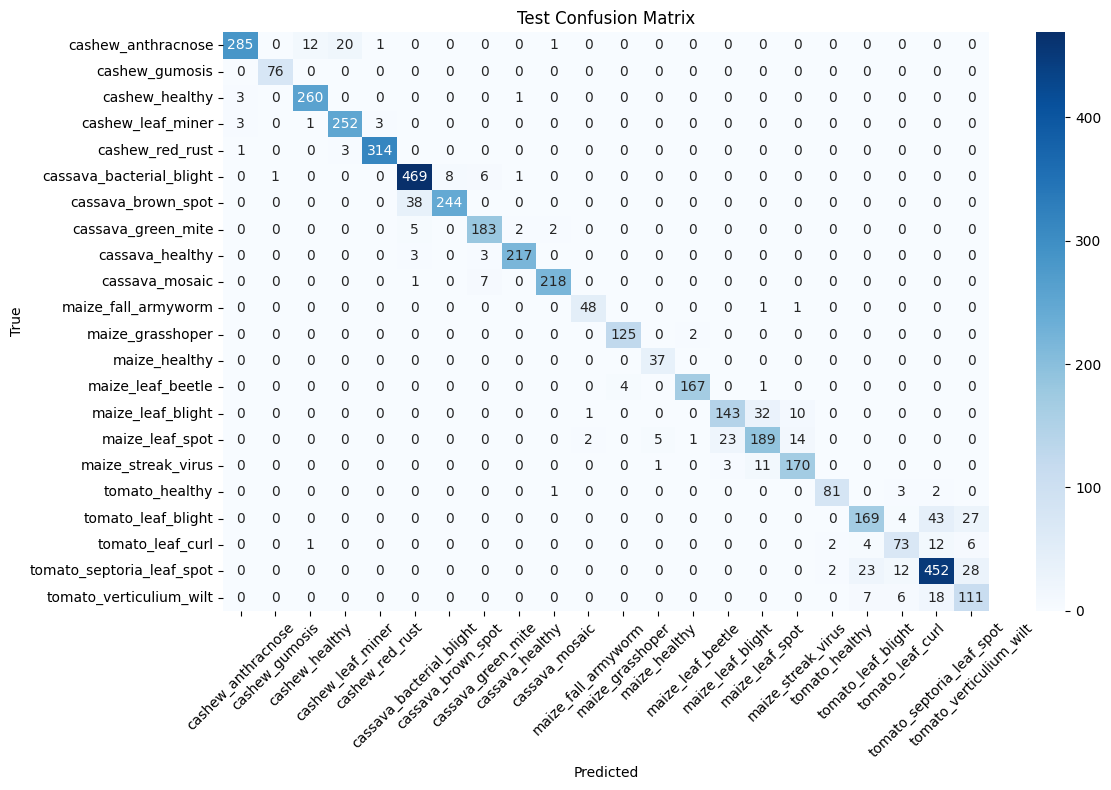

In [16]:
# Load your test set just like you did for train/val
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DataPlant_test",  # a directory you create with test images
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)
print(test_ds.class_names) 
class_names = test_ds.class_names
# Preprocess (cache + prefetch)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report & confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Map class indices back to names

y_true_names = [class_names[i] for i in y_true]
y_pred_names = [class_names[i] for i in y_pred]


# Print classification report
print(classification_report(y_true_names, y_pred_names, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 820ms/step - accuracy: 0.9084 - loss: 0.0345
Test Loss: 0.0330
Test Accuracy: 0.9070


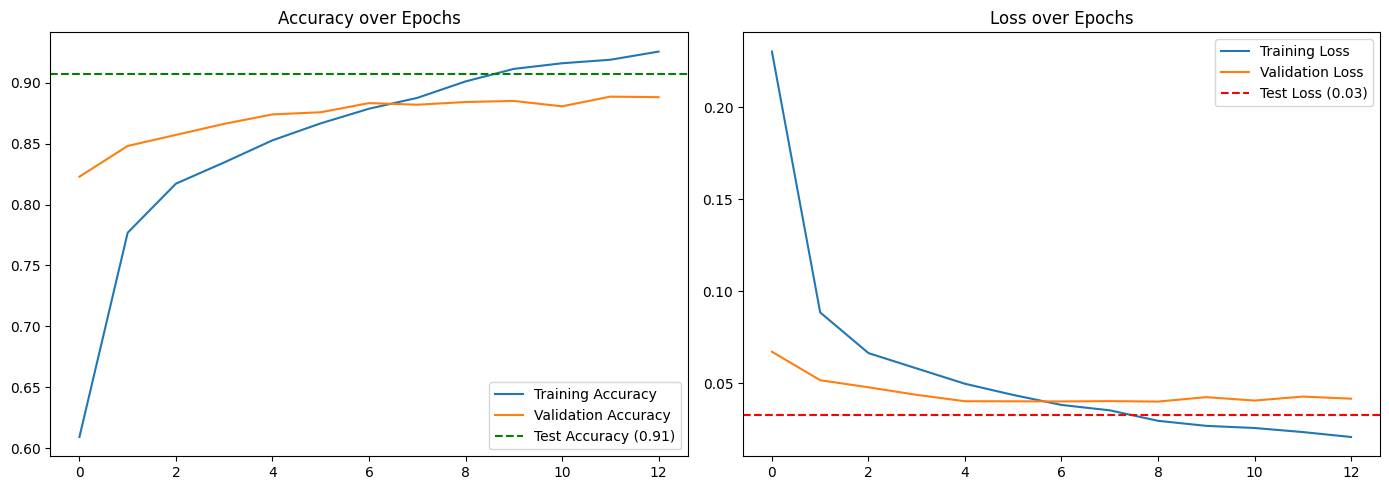

In [19]:
# After model.evaluate(test_ds)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plotting training vs validation + annotate test performance
def plot_training_history(history, test_acc, test_loss):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axhline(y=test_acc, color='green', linestyle='--', label=f'Test Accuracy ({test_acc:.2f})')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history, test_acc, test_loss)
